### `torchaudio`

In this notebook we are going to learn the basic audio manipulation using `pytorch` and `torchaudio`.

> When running this notebook on google colab you need o install the following packages:

1. `torchaudio`
2. `bibrosa`
3. `boto3`

... by running the following command:

```shell
!pip install -q torchaudio librosa boto3
```

In [3]:
!pip install -q torchaudio librosa boto3

     |████████████████████████████████| 1.9 MB 11.2 MB/s 
     |████████████████████████████████| 131 kB 51.5 MB/s 
     |████████████████████████████████| 831.4 MB 6.7 kB/s 
     |████████████████████████████████| 79 kB 7.3 MB/s 
     |████████████████████████████████| 8.0 MB 35.6 MB/s 
     |████████████████████████████████| 138 kB 52.2 MB/s 
     |████████████████████████████████| 127 kB 45.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.10.0+cu111 requires torch==1.9.0, but you have torch 1.9.1 which is incompatible.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.9.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


### Imports 1

In [4]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T


print(torch.__version__)
print(torchaudio.__version__)

1.9.0+cu111
0.9.1


### Data

We are going to work with audios data so for that we need to download some audios. The following cell list all the audio url's that we will be working with in this notebook.

In [5]:
import os

_SAMPLE_DIR = "_sample_data"

if not os.path.exists(_SAMPLE_DIR):
    os.mkdir(_SAMPLE_DIR)

In [6]:
SAMPLE_WAV_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav"
SAMPLE_WAV_PATH = os.path.join(_SAMPLE_DIR, "steam.wav")

SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
SAMPLE_WAV_SPEECH_PATH = os.path.join(_SAMPLE_DIR, "speech.wav")

SAMPLE_RIR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/room-response/rm1/impulse/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo.wav"
SAMPLE_RIR_PATH = os.path.join(_SAMPLE_DIR, "rir.wav")

SAMPLE_NOISE_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/distractors/rm1/babb/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav"
SAMPLE_NOISE_PATH = os.path.join(_SAMPLE_DIR, "bg.wav")

SAMPLE_MP3_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.mp3"
SAMPLE_MP3_PATH = os.path.join(_SAMPLE_DIR, "steam.mp3")

SAMPLE_GSM_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.gsm"
SAMPLE_GSM_PATH = os.path.join(_SAMPLE_DIR, "steam.gsm")

SAMPLE_TAR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit.tar.gz"
SAMPLE_TAR_PATH = os.path.join(_SAMPLE_DIR, "sample.tar.gz")
SAMPLE_TAR_ITEM = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

S3_BUCKET = "pytorch-tutorial-assets"
S3_KEY = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

In [7]:
YESNO_DATASET_PATH = os.path.join(_SAMPLE_DIR, "yes_no")
os.makedirs(YESNO_DATASET_PATH, exist_ok=True)
os.makedirs(_SAMPLE_DIR, exist_ok=True)

Downloading the data from the internet...

In [8]:
import requests

In [9]:
def _fetch_data():
    uri = [
        (SAMPLE_WAV_URL, SAMPLE_WAV_PATH),
        (SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH),
        (SAMPLE_RIR_URL, SAMPLE_RIR_PATH),
        (SAMPLE_NOISE_URL, SAMPLE_NOISE_PATH),
        (SAMPLE_MP3_URL, SAMPLE_MP3_PATH),
        (SAMPLE_GSM_URL, SAMPLE_GSM_PATH),
        (SAMPLE_TAR_URL, SAMPLE_TAR_PATH),
      ]
    for url, path in uri:
        with open(path, 'wb') as file_:
            file_.write(requests.get(url).content)
_fetch_data()

In [10]:
import multiprocessing

In [11]:
def _download_yesno():
    if os.path.exists(os.path.join(YESNO_DATASET_PATH, "waves_yesno.tar.gz")):
        return
    torchaudio.datasets.YESNO(root=YESNO_DATASET_PATH, download=True)

YESNO_DOWNLOAD_PROCESS = multiprocessing.Process(target=_download_yesno)
YESNO_DOWNLOAD_PROCESS.start()

In [ ]:
def _get_sample(path, resample=None):
    effects = [
        ["remix", "1"]
      ]
    if resample:
        effects.extend([
           ["lowpass", f"{resample // 2}"],
           ["rate", f'{resample}'],
        ])
    return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

In [ ]:
def get_speech_sample(*, resample=None):
    return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)

In [ ]:
def get_sample(*, resample=None):
    return _get_sample(SAMPLE_WAV_PATH, resample=resample)

In [ ]:
def get_rir_sample(*, resample=None, processed=False):
    rir_raw, sample_rate = _get_sample(SAMPLE_RIR_PATH, resample=resample)
    if not processed:
        return rir_raw, sample_rate
    rir = rir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
    rir = rir / torch.norm(rir, p=2)
    rir = torch.flip(rir, [1])
    return rir, sample_rate

In [ ]:
def get_noise_sample(*, resample=None):
    return _get_sample(SAMPLE_NOISE_PATH, resample=resample)

In [ ]:
def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()

In [ ]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

In [ ]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [ ]:
def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
         display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

In [ ]:
def inspect_file(path):
    print("-" * 10)
    print("Source:", path)
    print("-" * 10)
    print(f" - File size: {os.path.getsize(path)} bytes")
    print(f" - {torchaudio.info(path)}")


In [ ]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_mel_fbank(fbank, title=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Filter bank')
  axs.imshow(fbank, aspect='auto')
  axs.set_ylabel('frequency bin')
  axs.set_xlabel('mel bin')
  plt.show(block=False)

def get_spectrogram(
    n_fft = 400,
    win_len = None,
    hop_len = None,
    power = 2.0,
):
  waveform, _ = get_speech_sample()
  spectrogram = T.Spectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
      power=power,
  )
  return spectrogram(waveform)

def plot_pitch(waveform, sample_rate, pitch):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln2 = axis2.plot(
      time_axis, pitch[0], linewidth=2, label='Pitch', color='green')

  axis2.legend(loc=0)
  plt.show(block=False)

def plot_kaldi_pitch(waveform, sample_rate, pitch, nfcc):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Kaldi Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln1 = axis.plot(time_axis, pitch[0], linewidth=2, label='Pitch', color='green')
  axis.set_ylim((-1.3, 1.3))

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, nfcc.shape[1])
  ln2 = axis2.plot(
      time_axis, nfcc[0], linewidth=2, label='NFCC', color='blue', linestyle='--')

  lns = ln1 + ln2
  labels = [l.get_label() for l in lns]
  axis.legend(lns, labels, loc=0)
  plt.show(block=False)

DEFAULT_OFFSET = 201
SWEEP_MAX_SAMPLE_RATE = 48000
DEFAULT_LOWPASS_FILTER_WIDTH = 6
DEFAULT_ROLLOFF = 0.99
DEFAULT_RESAMPLING_METHOD = 'sinc_interpolation'

def _get_log_freq(sample_rate, max_sweep_rate, offset):
  """Get freqs evenly spaced out in log-scale, between [0, max_sweep_rate // 2]

  offset is used to avoid negative infinity `log(offset + x)`.

  """
  half = sample_rate // 2
  start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
  return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset

def _get_inverse_log_freq(freq, sample_rate, offset):
  """Find the time where the given frequency is given by _get_log_freq"""
  half = sample_rate // 2
  return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))

def _get_freq_ticks(sample_rate, offset, f_max):
  # Given the original sample rate used for generating the sweep,
  # find the x-axis value where the log-scale major frequency values fall in
  time, freq = [], []
  for exp in range(2, 5):
    for v in range(1, 10):
      f = v * 10 ** exp
      if f < sample_rate // 2:
        t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
        time.append(t)
        freq.append(f)
  t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
  time.append(t_max)
  freq.append(f_max)
  return time, freq

def plot_sweep(waveform, sample_rate, title, max_sweep_rate=SWEEP_MAX_SAMPLE_RATE, offset=DEFAULT_OFFSET):
  x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
  y_ticks = [1000, 5000, 10000, 20000, sample_rate//2]

  time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
  freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
  freq_y = [f for f in freq if f >= 1000 and f in y_ticks and f <= sample_rate // 2]

  figure, axis = plt.subplots(1, 1)
  axis.specgram(waveform[0].numpy(), Fs=sample_rate)
  plt.xticks(time, freq_x)
  plt.yticks(freq_y, freq_y)
  axis.set_xlabel('Original Signal Frequency (Hz, log scale)')
  axis.set_ylabel('Waveform Frequency (Hz)')
  axis.xaxis.grid(True, alpha=0.67)
  axis.yaxis.grid(True, alpha=0.67)
  figure.suptitle(f'{title} (sample rate: {sample_rate} Hz)')
  plt.show(block=True)

def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal

def benchmark_resample(
    method,
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=DEFAULT_LOWPASS_FILTER_WIDTH,
    rolloff=DEFAULT_ROLLOFF,
    resampling_method=DEFAULT_RESAMPLING_METHOD,
    beta=None,
    librosa_type=None,
    iters=5
):
  if method == "functional":
    begin = time.time()
    for _ in range(iters):
      F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=lowpass_filter_width,
                 rolloff=rolloff, resampling_method=resampling_method)
    elapsed = time.time() - begin
    return elapsed / iters
  elif method == "transforms":
    resampler = T.Resample(sample_rate, resample_rate, lowpass_filter_width=lowpass_filter_width,
                           rolloff=rolloff, resampling_method=resampling_method, dtype=waveform.dtype)
    begin = time.time()
    for _ in range(iters):
      resampler(waveform)
    elapsed = time.time() - begin
    return elapsed / iters
  elif method == "librosa":
    waveform_np = waveform.squeeze().numpy()
    begin = time.time()
    for _ in range(iters):
      librosa.resample(waveform_np, sample_rate, resample_rate, res_type=librosa_type)
    elapsed = time.time() - begin
    return elapsed / iters

### Audio io

#### Audio metadata
* `torchaudio.info` function fetches metadata of audio. You can provide a path-like object or file-like object.

Returns:

-  ``sample_rate`` is the sampling rate of the audio
-  ``num_channels`` is the number of channels
-  ``num_frames`` is the number of frames per channel
-  ``bits_per_sample`` is bit depth
-  ``encoding`` is the sample coding format

The values ``encoding`` can take are one of the following

-  ``"PCM_S"``: Signed integer linear PCM
-  ``"PCM_U"``: Unsigned integer linear PCM
-  ``"PCM_F"``: Floating point linear PCM
-  ``"FLAC"``: Flac, `Free Lossless Audio
   Codec <https://xiph.org/flac/>`__
-  ``"ULAW"``: Mu-law,
   [`wikipedia <https://en.wikipedia.org/wiki/%CE%9C-law_algorithm>`__]
-  ``"ALAW"``: A-law
   [`wikipedia <https://en.wikipedia.org/wiki/A-law_algorithm>`__]
-  ``"MP3"`` : MP3, MPEG-1 Audio Layer III
-  ``"VORBIS"``: OGG Vorbis [`xiph.org <https://xiph.org/vorbis/>`__]
-  ``"AMR_NB"``: Adaptive Multi-Rate
   [`wikipedia <https://en.wikipedia.org/wiki/Adaptive_Multi-Rate_audio_codec>`__]
-  ``"AMR_WB"``: Adaptive Multi-Rate Wideband
   [`wikipedia <https://en.wikipedia.org/wiki/Adaptive_Multi-Rate_Wideband>`__]
-  ``"OPUS"``: Opus [`opus-codec.org <https://opus-codec.org/>`__]
-  ``"GSM"``: GSM-FR
   [`wikipedia <https://en.wikipedia.org/wiki/Full_Rate>`__]
-  ``"UNKNOWN"`` None of above


-  ``bits_per_sample`` can be ``0`` for formats with compression and/or
   variable bit rate (such as mp3).
-  ``num_frames`` can be ``0`` for GSM-FR format.



In [12]:
metadata = torchaudio.info(SAMPLE_WAV_PATH)
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)


In [13]:
metadata = torchaudio.info(SAMPLE_MP3_PATH)
print(metadata)

metadata = torchaudio.info(SAMPLE_GSM_PATH)
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=110559, num_channels=2, bits_per_sample=0, encoding=MP3)
AudioMetaData(sample_rate=8000, num_frames=0, num_channels=1, bits_per_sample=0, encoding=GSM)


### Quering file-like object.

In [14]:
print("Source:", SAMPLE_WAV_URL)
with requests.get(SAMPLE_WAV_URL, stream=True) as response:
    metadata = torchaudio.info(response.raw)
print(metadata)

Source: https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav
AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)


### Loading audio data into Tensor

The `torch.load` function is used to load audio data into a pytorch tensor.

In [15]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV_SPEECH_PATH)

In [16]:
waveform

tensor([[0.0183, 0.0180, 0.0180,  ..., 0.0018, 0.0019, 0.0032]])

In [17]:
waveform.shape

torch.Size([1, 54400])

In [18]:
sample_rate

16000

### Printing the stats

In [19]:
def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()

In [20]:
print_stats(waveform, sample_rate, SAMPLE_WAV_SPEECH_PATH)

----------
Source: _sample_data/speech.wav
----------
Sample Rate: 16000
Shape: (1, 54400)
Dtype: torch.float32
 - Max:      0.668
 - Min:     -1.000
 - Mean:     0.000
 - Std Dev:  0.122

tensor([[0.0183, 0.0180, 0.0180,  ..., 0.0018, 0.0019, 0.0032]])



### Plotting the waveform

In [21]:
import matplotlib.pyplot as plt
import matplotlib

In [22]:
def plot_waveform(waveform, sample_rate, title="waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

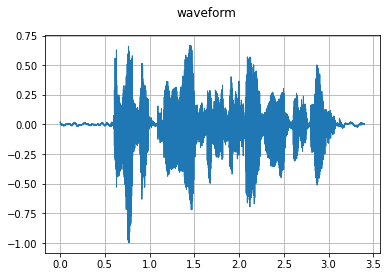

In [23]:
plot_waveform(waveform, sample_rate)

### Plotting the audio `specgram`

In [24]:
def plot_specgram(waveform, sample_rate, title="spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f'channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

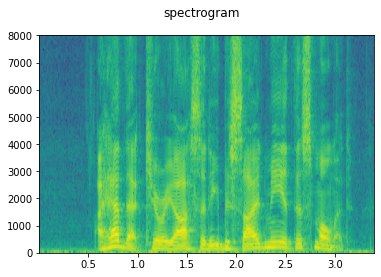

In [25]:
plot_specgram(waveform, sample_rate)

### Playing the audio

In [26]:
from IPython.display import Audio, display

In [27]:
def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()
    
    num_channels, num_frames = waveform.shape
    if num_channels == 1:
         display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

In [28]:
play_audio(waveform, sample_rate)

Creating a fake audio and play it.

In [29]:
fake_waveform = torch.rand([1, 54400], dtype=torch.float32)
fake_waveform

tensor([[0.6294, 0.0254, 0.1006,  ..., 0.4217, 0.3869, 0.9724]])

In [30]:
play_audio(fake_waveform, sample_rate)

### Loading from file like object

This allows to fetch audio data and decode at the same time from the location other than local file system. 


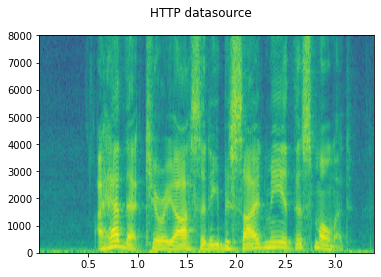

In [31]:
# Load audio data as HTTP request
with requests.get(SAMPLE_WAV_SPEECH_URL, stream=True) as response:
  waveform, sample_rate = torchaudio.load(response.raw)
plot_specgram(waveform, sample_rate, title="HTTP datasource")

In [32]:
import tarfile

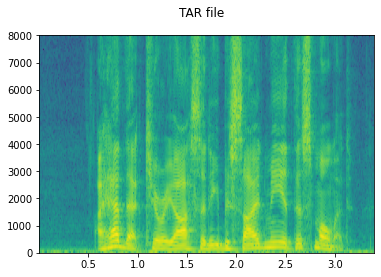

In [33]:
# Load audio from tar file
with tarfile.open(SAMPLE_TAR_PATH, mode='r') as tarfile_:
  fileobj = tarfile_.extractfile(SAMPLE_TAR_ITEM)
  waveform, sample_rate = torchaudio.load(fileobj)
plot_specgram(waveform, sample_rate, title="TAR file")

In [34]:
import boto3
from botocore.config import Config
from botocore import UNSIGNED

S3_BUCKET = "pytorch-tutorial-assets"
S3_KEY = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

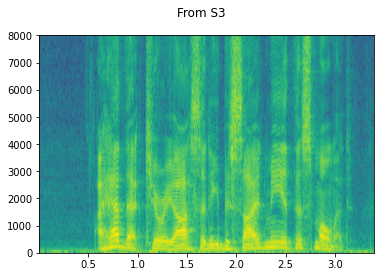

In [35]:
# Load audio from S3
client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
response = client.get_object(Bucket=S3_BUCKET, Key=S3_KEY)
waveform, sample_rate = torchaudio.load(response['Body'])
plot_specgram(waveform, sample_rate, title="From S3")

### Saving audio to file

To save audio data in the formats intepretable by common applications, you can use ``torchaudio.save``.

This function accepts ``path-like`` object and ``file-like`` object.

When passing ``file-like`` object, you also need to provide format argument so that the function knows which format it should be using. In case of ``path-like`` object, the function will detemine the format based on the extension. If you are saving to a file without extension, you need to provide format argument.

When saving as WAV format, the default encoding for ``float32`` Tensor is 32-bit floating-point PCM. You can provide encoding and ``bits_per_sample`` argument to change this. For example, to save data in 16 bit signed integer PCM, you can do the following.

**Note** Saving data in encodings with lower bit depth reduces the resulting file size but loses precision.

In [37]:
path = "save_example_default.wav"
torchaudio.save(path, waveform, sample_rate)

In [38]:
waveform, sample_rate = torchaudio.load(path)
play_audio(fake_waveform, sample_rate)

In [39]:
# Save as 16-bit signed integer Linear PCM
# The resulting file occupies half the storage but loses precision
path = "save_example_PCM_S16.wav"
torchaudio.save(
    path, waveform, sample_rate,
    encoding="PCM_S", bits_per_sample=16)

In [40]:
waveform, sample_rate = torchaudio.load(path)
play_audio(fake_waveform, sample_rate)

``torchaudio.save`` can also handle other formats. To name a few:

```py
formats = [
  "mp3",
  "flac",
  "vorbis",
  "sph",
  "amb",
  "amr-nb",
  "gsm",
]

for format in formats:
  path = f"save_example.{format}"
  torchaudio.save(path, waveform, sample_rate, format=format)
  inspect_file(path)
```

### Saving to file-like object
When saving to file-like object, ``format`` argument is required.

In [41]:
import io

In [42]:
# Saving to Bytes buffer
buffer_ = io.BytesIO()
torchaudio.save(buffer_, waveform, sample_rate, format="wav")

buffer_.seek(0)
print(buffer_.read(16))

b'RIFF2R\x03\x00WAVEfmt '


### Resampling

### References

1. [audio_preprocessing_tutorial](https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html)
2. [Docs](https://pytorch.org/audio/stable/torchaudio.html)